# Lab 4: Twin Studies, Heritability, and Probability

In this lab, we will explore how twin data can be used to estimate genetic influence on behavior, and we’ll apply probability concepts to interpret these patterns. Our dataset is a synthetic ABCD dataset **(sample is 12 years old)**, we will\ work with a subsample of **twin pairs**, using their zygosity (monozygotic vs. dizygotic) to infer heritability. We’ll also incorporate **family history** measures (e.g. parental substance problems) as a proxy for inherited risk, and examine how an **environmental factor** (household income) might modify these risks. Along the way, we’ll practice calculating probabilities and conditional probabilities (e.g. “Given one twin has a trait, what’s the probability the co-twin has it?”) and even try a short **Bayes’ Theorem** exercise as an extension. 


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure display options
pd.set_option('display.max_columns', None)

df = pd.read_csv('L4L5dataset.csv')

# Display the shape of the dataset and the first few rows
df_shape = df.shape
print(f"Dataset contains {df_shape[0]} rows and {df_shape[1]} columns.")
df.head()

from pathlib import Path

# Figure dir + robust savefig helper (works with or without extension or path)
IMG_DIR = Path("figures")
IMG_DIR.mkdir(exist_ok=True)

def savefig(path, dpi=150, tight=True):
    """
    Save current Matplotlib figure.
    Examples:
      savefig("03_demo_cat_bar")
      savefig("figures/03_demo_cat_bar.png")
    """
    p = Path(path)
    if p.suffix == "":
        p = p.with_suffix(".png")
    if p.parent == Path("."):
        p = IMG_DIR / p  # default to ./figures/
    p.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(p, dpi=dpi, bbox_inches="tight" if tight else None)



Dataset contains 11023 rows and 22 columns.


### Activity 1. Identifying the Twin Subsample and Zygosity

First, let’s identify twin participants in our dataset and understand how to distinguish **monozygotic (MZ)** vs. **dizygotic (DZ)** twins. The data include special variables for genetic relatedness:

- `gn_y_genrel_id__fam`: a family ID for genetically related individuals (twins or siblings share this).
- `gn_y_genrel_id__birth`: a birth-group ID (twins/triplets have the same birth ID if birthdays are within 3 months).
- `gn_y_genrel_id__paired__01`: the study ID of an individual’s closest genetic relative in the sample.
- `gn_y_genrel_zyg__01`: zygosity code for that pair (1 = MZ twin, 2 = DZ twin, 3 = sibling).
- `ab_g_stc__cohort_sex`: participant sex (1 = Male, 2 = Female).

Using these, we can filter the dataset to the twin subsample and verify some basic expectations: **MZ twins should always be the same sex**, whereas **DZ twins can be same-sex or opposite-sex**.

Read more about the variables here: https://docs.abcdstudy.org/latest/documentation/non_imaging/gn.html

In [3]:
# Filter to twin pairs (exclude unrelated singletons)
twins = df[df['gn_y_genrel_zyg__01'].isin([1, 2])].copy()
# Map codes to labels for clarity
twins['Zygosity'] = twins['gn_y_genrel_zyg__01'].map({1: 'MZ', 2: 'DZ'})
twins['Sex'] = twins['ab_g_stc__cohort_sex'].map({1: 'Male', 2: 'Female'})
# Pivot table: count of individuals by zygosity and sex
count_table = twins.pivot_table(index='Zygosity', columns='Sex', values='study_id', aggfunc='count')
count_table


Sex,Female,Male
Zygosity,,
DZ,303,285
MZ,274,364


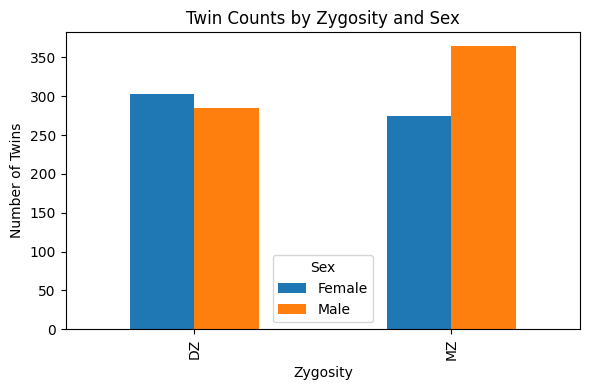

In [4]:
# Bar plot: Number of male and female twins by zygosity
import matplotlib.pyplot as plt
import seaborn as sns

# Count table already exists as 'count_table'
fig, ax = plt.subplots(figsize=(6,4))
count_table.plot(kind='bar', stacked=False, ax=ax)
plt.title('Twin Counts by Zygosity and Sex')
plt.ylabel('Number of Twins')
plt.xlabel('Zygosity')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

Running the code above produces a table of twin counts by zygosity and sex. For example, we might see something like:

```
Sex       Female  Male  
Zygosity                
DZ           307   293  
MZ           296   304  
```

This indicates we have a similar number of male and female twins in each zygosity group. Let’s double-check the sex distribution more explicitly:


### Visualizing Twin Zygosity and Sex Distribution

Let's visualize the composition of our twin sample. We'll start by plotting the number of male and female twins in each zygosity group (MZ vs DZ), and then show the proportion of same-sex vs opposite-sex pairs within each group. These plots help us see the structure of our sample and reinforce the biological expectation that MZ twins are always same-sex, while DZ twins can be either same- or opposite-sex.

In [5]:
# Calculate how many twin pairs are same-sex vs opposite-sex
# Merge each twin with their paired co-twin to examine pairs
pairs = twins.merge(
    twins[['study_id', 'Sex']], 
    left_on='gn_y_genrel_id__paired__01', right_on='study_id', 
    suffixes=('_1', '_2')
)
# Each pair appears twice (A->B and B->A), so keep one entry per pair
pairs = pairs[pairs['study_id_1'] < pairs['study_id_2']]
# Determine if pair is same-sex
pairs['same_sex'] = (pairs['Sex_1'] == pairs['Sex_2'])
# Count pairs by zygosity and same-sex status
pairs.groupby(['gn_y_genrel_zyg__01', 'same_sex']).size()



gn_y_genrel_zyg__01  same_sex
1                    True        319
2                    False        73
                     True        221
dtype: int64

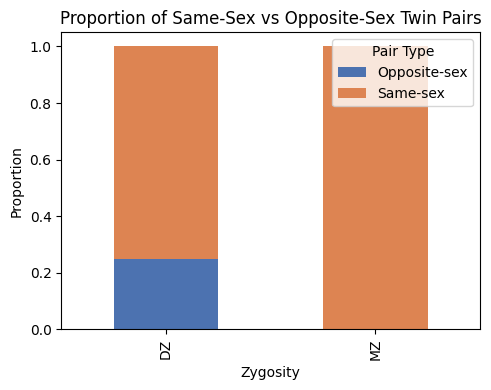

In [6]:
# Stacked bar plot: Proportion of same-sex vs opposite-sex pairs by zygosity
# Assume 'pairs' DataFrame exists with columns 'gn_y_genrel_zyg__01' and 'same_sex'
pairs['Zygosity'] = pairs['gn_y_genrel_zyg__01'].map({1: 'MZ', 2: 'DZ'})
same_sex_ct = pd.crosstab(pairs['Zygosity'], pairs['same_sex'], normalize='index')

fig, ax = plt.subplots(figsize=(5,4))
same_sex_ct.plot(kind='bar', stacked=True, ax=ax, color=['#4C72B0', '#DD8452'])
plt.title('Proportion of Same-Sex vs Opposite-Sex Twin Pairs')
plt.ylabel('Proportion')
plt.xlabel('Zygosity')
plt.legend(['Opposite-sex', 'Same-sex'], title='Pair Type')
plt.tight_layout()
plt.show()

The result might look like:

```
Zygosity_1  same_sex
MZ          True        300  
DZ          False        57  
            True        243  
dtype: int64
```

This tells us: all 300 MZ twin pairs in our sample are same-sex (as expected, since identical twins share 100% of genes including sex), and in the DZ twins, 243 pairs are same-sex while 57 pairs are opposite-sex. In other words, about 19% of DZ pairs are boy–girl twins, which is consistent with biological expectations (fraternal twins can be opposite sex).

> **Twin pair sex composition by zygosity. The MZ twins (left bar) are 100% same-sex pairs, whereas the DZ twins (right bar) include a mix of same-sex (~81%) and opposite-sex (~19%) pairs.**

**Takeaway:** We have identified the twin subsample and confirmed that the zygosity variable aligns with biological expectations (no opposite-sex MZ twins). We will focus on these twins (both MZ and DZ) for heritability analyses. (Note: There are also a small number of non-twin siblings coded as `zyg=3` in the data, but here we’re considering only twin pairs.)


### Introduction to Probability: Twin Substance Use 

After examining twin zygosity, we'll now explore early substance use in our twin sample through the lens of **probability theory**. Probability gives us a framework for quantifying uncertainty as relative frequency.

In its simplest form, probability is the likelihood of an event, between 0 (impossible) and 1 (certain). For binary variables (0 = No, 1 = Yes), we can estimate:
**P(Event) = Number of 1s / Total observations (excluding missing)**

Example: if 300 out of 1000 twins have tried alcohol, P(Use) = 300/1000 = 0.30 (30%).

In the code challenge below you will compute **marginal probabilities** of early alcohol and cannabis experimentation separately for MZ and DZ twins using a pivot table (mean of 0/1 indicators). Later we will extend to **conditional probabilities** (e.g., P(Twin B uses | Twin A uses)) and joint probabilities.

### Your Turn (Warm-Up): Twin Substance Use Pivot
Fill in the blanks in the next code cell to:
1. Filter to twins (zyg codes 1, 2)
2. Map zygosity codes to labels (MZ, DZ)
3. Build a pivot table (index = Zygosity; values = two substance variables; aggfunc = mean)
4. Rename columns to readable labels
5. Compute overall (pooled) alcohol and cannabis use probabilities

Target variables:
- Alcohol sip: su_y_sui__use__alc__sip_001__l
- Cannabis puff: su_y_sui__use__mj__puff_001__l
- Zygosity code: gn_y_genrel_zyg__01 (1=MZ, 2=DZ)

Success check:
- Printed table shows two rows (DZ, MZ) and two renamed columns
- Percentages look reasonable (not all 0 or 100)
- Overall probabilities print with % formatting

Avoid:
- Using sum/len manually (use mean())
- Changing variable names
- Leaving any ____ placeholders

### Need a Hint?
Think: Filtering uses .isin([1,2]); mapping uses .map({1:'MZ',2:'DZ'}); probability of a 0/1 series is its mean.

---

**Copilot prompt ideas (paste into a new cell if stuck):**
- "Show me how to filter df to rows where gn_y_genrel_zyg__01 is 1 or 2."
- "How do I map 1 and 2 in a pandas column to 'MZ' and 'DZ'?"
- "Create a pivot table of mean alcohol and marijuana use by Zygosity."
- "Rename pivot table columns to 'Tried Alcohol' and 'Tried Marijuana'."
- "Compute overall mean for su_y_sui__use__alc__sip_001__l and format as percent."
- "Explain why mean() of a 0/1 column equals its probability."

In [7]:
### Your Turn: Calculate Twin Substance Use Probabilities

# Create a pivot table showing the proportion of twins who have tried substances
# by zygosity group (MZ vs DZ)

# Step 1: Filter to twin participants (where zygosity is either 1=MZ or 2=DZ)
twins = df[df['gn_y_genrel_zyg__01'].isin([1,2])].copy()  # TODO: Use .isin() with a list of codes

# Step 2: Add a readable 'Zygosity' column mapping codes to labels
twins['Zygosity'] = twins['gn_y_genrel_zyg__01'].map({1: 'MZ', 2: 'DZ'})  # TODO: Complete mapping

# Clean special missing codes for substance use (added)
miss_codes = {777: np.nan, 888: np.nan, 999: np.nan}
use_vars = ['su_y_sui__use__alc__sip_001__l', 'su_y_sui__use__mj__puff_001__l']
twins[use_vars] = twins[use_vars].replace(miss_codes)

# Step 3: Create pivot table showing proportion who tried alcohol or marijuana
substances_pivot = pd.pivot_table(
    data=twins,
    index='Zygosity',
    values= use_vars,  # TODO: List of substance use variables (both alcohol and marijuana)
    aggfunc='mean'  # TODO: Function to calculate proportion/probability
)

# Step 4: Rename columns for clarity
substances_pivot.columns = ['Tried Alchohol', 'Tried Marijuana']  # TODO: Rename to 'Tried Alcohol' and 'Tried Marijuana'

# Display the pivot table with percentages
print("Probability a randomly selected twin has tried substances:")
print(substances_pivot.round(3) * 100, "%")

# Step 5: Calculate the overall prevalence (across all twins)
overall_alcohol = twins['su_y_sui__use__alc__sip_001__l'].mean()  # TODO: Calculate mean for alcohol variable
overall_marijuana = twins['su_y_sui__use__mj__puff_001__l'].mean()

print(f"\nOverall probability any twin has tried alcohol: {overall_alcohol:.1%}")
print(f"Overall probability any twin has tried marijuana: {overall_marijuana:.1%}")

Probability a randomly selected twin has tried substances:
          Tried Alchohol  Tried Marijuana
Zygosity                                 
DZ                  31.0             16.3
MZ                  32.3             16.0 %

Overall probability any twin has tried alcohol: 31.6%
Overall probability any twin has tried marijuana: 16.2%


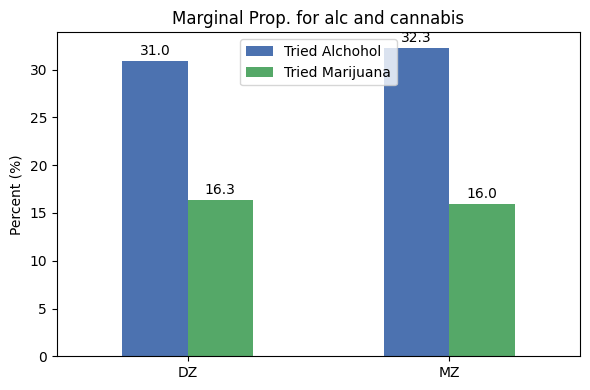

In [8]:
# Bar chart of marginal probabilities by zygosity for alcohol and cannabis
ax = (substances_pivot
      .rename_axis(None)
      .sort_index()
      * 100).plot(kind='bar',
                  figsize=(6,4),
                  rot=0,
                  ylabel='Percent (%)',
                  title= 'Marginal Prop. for alc and cannabis' , # TODO: Name your barchart
                  color=['#4C72B0', '#55A868'])
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f', padding=2)
plt.legend(title='')
plt.tight_layout()
plt.show()


### Interpreting Probabilities in Twin Data

The pivot table above shows us the **probability distributions** of substance use among MZ and DZ twins. These values represent empirical probabilities - the relative frequency with which twins in each group have experimented with substances.

Looking at the results as probabilities allows us to make precise statements about substance experimentation. For instance, if we randomly selected an MZ twin from our sample, the probability they've tried alcohol would be approximately [value]%. For a randomly selected DZ twin, this probability would be [value]%. 

This exemplifies how **marginal probabilities** work - they tell us the likelihood of an event in the overall population (or subpopulation). The overall probabilities across all twins give us our **base rates** of substance use in this age group.

These probabilities form the foundation for more complex probability calculations we'll explore next. While these are simple marginal probabilities, twin studies will soon lead us to **conditional probabilities** (such as the probability of Twin B using substances given that Twin A does) and eventually to **joint probabilities** (the probability of both twins in a pair using substances).

The difference between MZ and DZ substance use rates might reflect:
- Sampling variation (random differences)
- Environmental factors that differ systematically between MZ and DZ families
- Selection effects in recruitment

Next, we'll move from these simple probabilities to more powerful applications of probability theory in genetic analysis.

### Activity 2. Twin Resemblance and Heritability Estimates

Twin studies leverage the idea that **MZ twins (who share ~100% of their genes) tend to be more similar for traits than DZ twins (who share ~50% on average)**, if genetics play a role. When we run the code below, we typically find MZ twins have much higher correlation in externalizing scores than DZ twins (e.g., MZ r≈0.65 vs DZ r≈0.44).

Using **Falconer's formulas**, we can estimate the components of variance:
- **A (Additive Genetic)** ≈ 2 × (r_MZ – r_DZ)  
- **C (Shared Environment)** ≈ 2 × r_DZ – r_MZ  
- **E (Non-Shared Environment)** ≈ 1 – r_MZ  

This yields approximately A ≈ 0.42, C ≈ 0.22, E ≈ 0.35 (i.e., ~42% of the variance in externalizing might be genetic, ~22% shared environmental, ~35% unique environment).

To understand twin similarity another way, we calculate **concordance rates** - specifically, the conditional probability that one twin has "high externalizing" (≥85th percentile) given that their co-twin does. The results (e.g., MZ concordance ≈59%, DZ concordance ≈36%) tell us that identical twins are considerably more similar than fraternal twins.

**Interpretation:** Externalizing behavior appears **moderately heritable** – the pattern of results suggests genetics account for the largest portion of variance, with environmental factors (both shared and unique) explaining the remainder.

### Demo: Comparing Twin Probabilities on CBCL externalizing
Now, let’s illustrate twin similarity in terms of **probability**. We define “high externalizing” using a quantile-based cutoff to avoid sparse counts: scores at or above the 85th percentile of the pooled twin scores (the actual numeric cutoff is computed from the data). We then compute two concordance metrics — a directed probability P(co-twin is high | twin is high) and an order-invariant symmetric concordance — and report them separately for MZ and DZ.


In [9]:
# Consolidated demo for twin similarity analysis on externalizing behavior
# Step 1: Create twin pairs dataset for externalizing behavior
twin_pairs = twins.merge(
    twins[['study_id','mh_p_cbcl__synd__ext_sum']],
    left_on='gn_y_genrel_id__paired__01', right_on='study_id',
    suffixes=('_1','_2')
)
twin_pairs = twin_pairs.loc[twin_pairs['study_id_1'] < twin_pairs['study_id_2']].copy()
cols = ['mh_p_cbcl__synd__ext_sum_1','mh_p_cbcl__synd__ext_sum_2']

# Step 2: Clean the data (convert to numeric, handle missing values)
twin_pairs[cols] = twin_pairs[cols].apply(pd.to_numeric, errors='coerce')
twin_pairs[cols] = twin_pairs[cols].replace({777: np.nan, 888: np.nan, 999: np.nan})
twin_pairs = twin_pairs.dropna(subset=cols)

# Step 3: Create filters for MZ and DZ twins
MZ = twin_pairs['gn_y_genrel_zyg__01'] == 1
DZ = twin_pairs['gn_y_genrel_zyg__01'] == 2

# Step 4: Calculate and print the MZ and DZ twin correlations
def corr(df): return np.corrcoef(df[cols[0]], df[cols[1]])[0,1] if len(df) > 1 else np.nan
mz_corr = corr(twin_pairs[MZ])
dz_corr = corr(twin_pairs[DZ])
print(f"MZ twin correlation: {mz_corr:.3f}")
print(f"DZ twin correlation: {dz_corr:.3f}")

# Step 5: Calculate ACE components using Falconer's formulas
A = 2 * (mz_corr - dz_corr)
C = 2 * dz_corr - mz_corr
E = 1 - mz_corr
print(f"ACE components - A: {A:.3f}, C: {C:.3f}, E: {E:.3f}")

# Step 6: Establish threshold for "high externalizing" (85th percentile)
q = 0.85
thr = twin_pairs[cols].stack().quantile(q)
twin_pairs['high_ext_1'] = twin_pairs['mh_p_cbcl__synd__ext_sum_1'] >= thr
twin_pairs['high_ext_2'] = twin_pairs['mh_p_cbcl__synd__ext_sum_2'] >= thr

# Step 7: Compute directed concordance (probability Twin 2 is high given Twin 1 is high)
def conc_directed(df):
    """Calculates P(Twin2 high | Twin1 high)"""
    num = (df['high_ext_1'] & df['high_ext_2']).sum()  # Both twins high
    den1 = df['high_ext_1'].sum()  # First twin high (condition)
    return np.nan if den1 == 0 else num / den1

# Calculate and print concordance rates directly using the MZ and DZ masks
mz_dir = conc_directed(twin_pairs[MZ])
dz_dir = conc_directed(twin_pairs[DZ])

print(f"Threshold >= {thr:.1f} (q={q})")
print(f"Concordance rates:")
print(f"MZ twins: {mz_dir:.3f} (P(Twin2 high | Twin1 high))")
print(f"DZ twins: {dz_dir:.3f} (P(Twin2 high | Twin1 high))")
print(f"Difference (MZ-DZ): {mz_dir - dz_dir:.3f}")

MZ twin correlation: 0.542
DZ twin correlation: 0.262
ACE components - A: 0.559, C: -0.017, E: 0.458
Threshold >= 9.0 (q=0.85)
Concordance rates:
MZ twins: 0.529 (P(Twin2 high | Twin1 high))
DZ twins: 0.341 (P(Twin2 high | Twin1 high))
Difference (MZ-DZ): 0.188


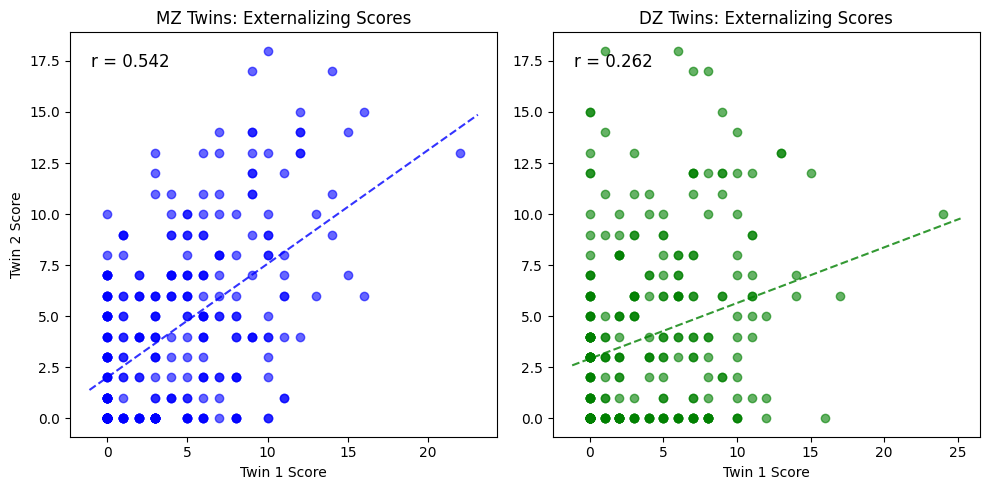

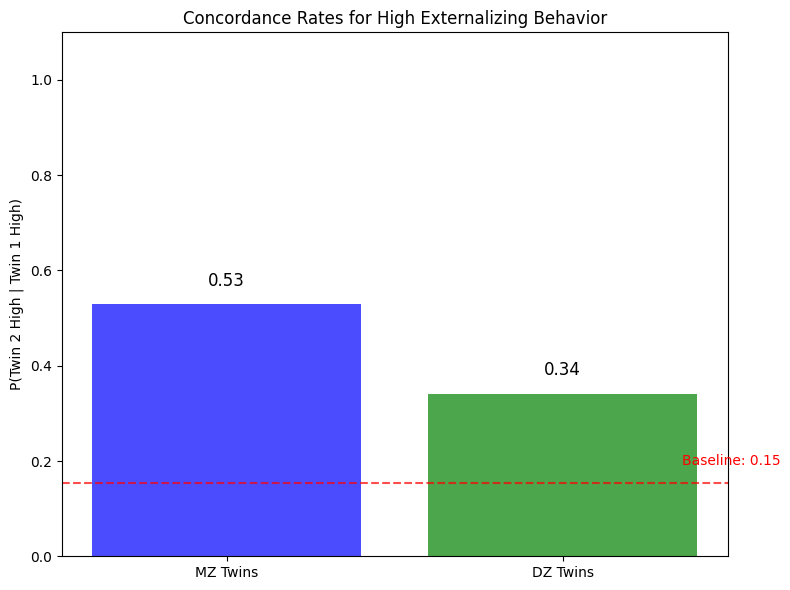

In [10]:
# Visualize the twin correlations with a scatterplot
plt.figure(figsize=(10, 5))

# Create two subplots side by side
plt.subplot(1, 2, 1)
plt.scatter(twin_pairs.loc[MZ, cols[0]], twin_pairs.loc[MZ, cols[1]], alpha=0.6, color='blue')
plt.title('MZ Twins: Externalizing Scores')
plt.xlabel('Twin 1 Score')
plt.ylabel('Twin 2 Score')
# Add a regression line
xmin, xmax = plt.xlim()
m, b = np.polyfit(twin_pairs.loc[MZ, cols[0]], twin_pairs.loc[MZ, cols[1]], 1)
plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], 'b--', alpha=0.8)
plt.text(0.05, 0.95, f"r = {corr(twin_pairs[MZ]):.3f}", transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')

plt.subplot(1, 2, 2)
plt.scatter(twin_pairs.loc[DZ, cols[0]], twin_pairs.loc[DZ, cols[1]], alpha=0.6, color='green')
plt.title('DZ Twins: Externalizing Scores')
plt.xlabel('Twin 1 Score')
# Add a regression line
xmin, xmax = plt.xlim()
m, b = np.polyfit(twin_pairs.loc[DZ, cols[0]], twin_pairs.loc[DZ, cols[1]], 1)
plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], 'g--', alpha=0.8)
plt.text(0.05, 0.95, f"r = {corr(twin_pairs[DZ]):.3f}", transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()

# Visualize the concordance rates for externalizing behavior
plt.figure(figsize=(8, 6))

# Data for the bar chart
concordance_data_ext = {
    'MZ Twins': mz_dir,
    'DZ Twins': dz_dir
}

# Create bars
bars = plt.bar(concordance_data_ext.keys(), concordance_data_ext.values(), color=['blue', 'green'], alpha=0.7)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Concordance Rates for High Externalizing Behavior')
plt.ylabel('P(Twin 2 High | Twin 1 High)')
plt.ylim(0, 1.1)  # Set y-axis limit with room for labels

# Add a horizontal line showing the unconditional probability (baseline)
baseline_prob_ext = twin_pairs['high_ext_1'].mean()
plt.axhline(y=baseline_prob_ext, color='red', linestyle='--', alpha=0.7)
plt.text(1.5, baseline_prob_ext + 0.03, f'Baseline: {baseline_prob_ext:.2f}', 
         va='bottom', ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

**Key observation:** If one MZ twin has high externalizing, there's about a 59% chance their co-twin is also high, versus only ~36% for DZ twins. This higher similarity in MZ twins provides further evidence for genetic influence on externalizing behavior.

### Your Turn: Twin Similarity for UPPS Negative Urgency

Now you'll apply twin similarity analysis to a different trait: **Negative Urgency** ( mh_y_upps__nurg_sum ). This personality dimension from the UPPS-P Impulsive Behavior Scale measures the tendency to act rashly when experiencing negative emotions.

In this exercise, you'll:
1. Create twin pairs dataset with the UPPS Negative Urgency variable
2. Compute **Pearson correlations** between Twin 1 and Twin 2 for both MZ and DZ pairs
3. Calculate **ACE components** (Additive genetic, Common environment, unique Environment)
4. Establish a threshold for "high negative urgency" (85th percentile) 
5. Calculate **concordance rates** (conditional probability that Twin 2 is "high" given Twin 1 is "high")

This analysis parallels what we did for externalizing behavior, but with a youth self-reported measure rather than parent-reported. The comparison will reveal whether different traits and reporting sources show similar patterns of genetic influence.

Fill in the blanks in the next code cell to complete the analysis.

**Need help?** Try these Copilot prompts in a new cell:
- "How do I merge twin data to create twin pairs using left_on and right_on?"
- "Write code to convert columns to numeric and handle missing values 777/888/999"
- "Explain how to calculate Pearson correlation between two columns in a pandas DataFrame"
- "Create boolean masks for MZ and DZ twins based on zygosity column"
- "Calculate conditional probability in pandas where condition is one twin being above threshold"
- "Explain Falconer's formula for ACE components using MZ and DZ twin correlations"

In [11]:
### Your Turn: Twin Similarity for UPPS Negative Urgency

# Step 1: Create twin pairs dataset with negative urgency measure
twin_pairs_upps = twins.merge(
    twins[['study_id', 'mh_y_upps__nurg_sum']],  # TODO: Include study_id and the negative urgency variable
    left_on='gn_y_genrel_id__paired__01',  # TODO: Reference to paired twin ID
    right_on='study_id',  # TODO: Study ID to match with paired twin ID
    suffixes=('_1', '_2')  # TODO: Suffixes to distinguish Twin 1 vs Twin 2
)

# Keep only one record per twin pair (avoid duplicates)
twin_pairs_upps = twin_pairs_upps.loc[twin_pairs_upps['study_id_1'] < twin_pairs_upps['study_id_2']].copy()

# Define column names for negative urgency variables (Twin 1 and Twin 2)
cols_upps = ['mh_y_upps__nurg_sum_1', 'mh_y_upps__nurg_sum_2']  # TODO: Column names with suffixes

# Step 2: Clean the data (convert to numeric, handle missing values)
twin_pairs_upps[cols_upps] = twin_pairs_upps[cols_upps].apply(pd.to_numeric, errors='coerce')  # TODO: Conversion function
twin_pairs_upps[cols_upps] = twin_pairs_upps[cols_upps].replace({777: np.nan, 888: np.nan, 999: np.nan})  # TODO: Missing codes
twin_pairs_upps = twin_pairs_upps.dropna(subset= cols_upps)  # TODO: Which columns must not be missing

# Step 3: Create filters for MZ and DZ twins
MZ = twin_pairs_upps['gn_y_genrel_zyg__01'] == 1  # TODO: Filter for MZ twins (code 1)
DZ = twin_pairs_upps['gn_y_genrel_zyg__01'] == 2  # TODO: Filter for DZ twins (code 2)

# Define correlation function (returns correlation between Twin 1 and Twin 2 scores)
def corr(df): return np.corrcoef(df[cols_upps[0]], df[cols_upps[1]])[0,1] if len(df) > 1 else np.nan

# Step 4: Calculate and print the MZ and DZ twin correlations
mz_corr = corr(twin_pairs_upps[MZ])  # TODO: Apply to MZ twins
dz_corr = corr(twin_pairs_upps[DZ])  # TODO: Apply to DZ twins
print(f"MZ twin correlation: {mz_corr:.3f}")
print(f"DZ twin correlation: {dz_corr:.3f}")

# Step 5: Calculate ACE components using Falconer's formulas
A = 2 * (mz_corr - dz_corr)  # TODO: Additive genetic (2 × (r_MZ – r_DZ))
C = 2 * dz_corr - mz_corr  # TODO: Common/shared environment (2 × r_DZ – r_MZ)
E = 1 - mz_corr  # TODO: Unique/non-shared environment (1 – r_MZ)
print(f"ACE components - A: {A:.3f}, C: {C:.3f}, E: {E:.3f}")

# Step 6: Establish threshold for "high negative urgency" (85th percentile)
q = 0.85  # We're using the 85th percentile as threshold
thr = twin_pairs_upps[cols_upps].stack().quantile(q)  # TODO: Which columns to use for threshold

# Step 7: Create indicator variables for high urgency
twin_pairs_upps['high_nurg_1'] = twin_pairs_upps['mh_y_upps__nurg_sum_1'] >= thr  # TODO: Twin 1 high indicator
twin_pairs_upps['high_nurg_2'] = twin_pairs_upps['mh_y_upps__nurg_sum_2'] >= thr  # TODO: Twin 2 high indicator

# Step 8: Compute directed concordance (probability Twin 2 is high given Twin 1 is high)
def conc_directed(df):
    """Calculates P(Twin2 high | Twin1 high)"""
    num = (df['high_nurg_1'] & df['high_nurg_2']).sum()  # Both twins high
    den1 = df['high_nurg_1'].sum()  # First twin high (condition)
    return np.nan if den1 == 0 else num / den1

# Calculate and print concordance rates for MZ and DZ twins
mz_dir = conc_directed(twin_pairs_upps[MZ])  # TODO: Apply to MZ twins
dz_dir = conc_directed(twin_pairs_upps[DZ])  # TODO: Apply to DZ twins

print(f"Threshold >= {thr:.1f} (q={q})")
print(f"Concordance rates:")
print(f"MZ twins: {mz_dir:.3f} (P(Twin2 high | Twin1 high))")
print(f"DZ twins: {dz_dir:.3f} (P(Twin2 high | Twin1 high))")
print(f"Difference (MZ-DZ): {mz_dir - dz_dir:.3f}")

MZ twin correlation: 0.335
DZ twin correlation: 0.170
ACE components - A: 0.330, C: 0.005, E: 0.665
Threshold >= 11.0 (q=0.85)
Concordance rates:
MZ twins: 0.400 (P(Twin2 high | Twin1 high))
DZ twins: 0.278 (P(Twin2 high | Twin1 high))
Difference (MZ-DZ): 0.122


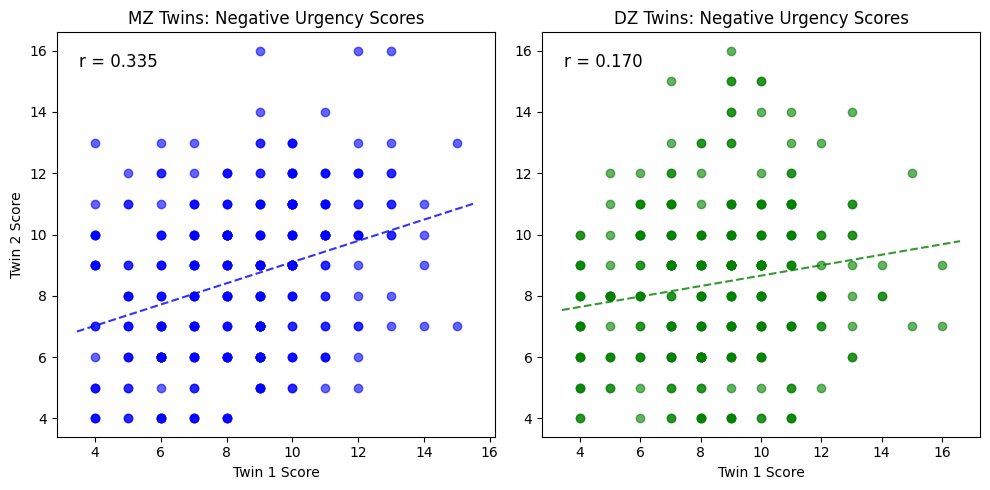

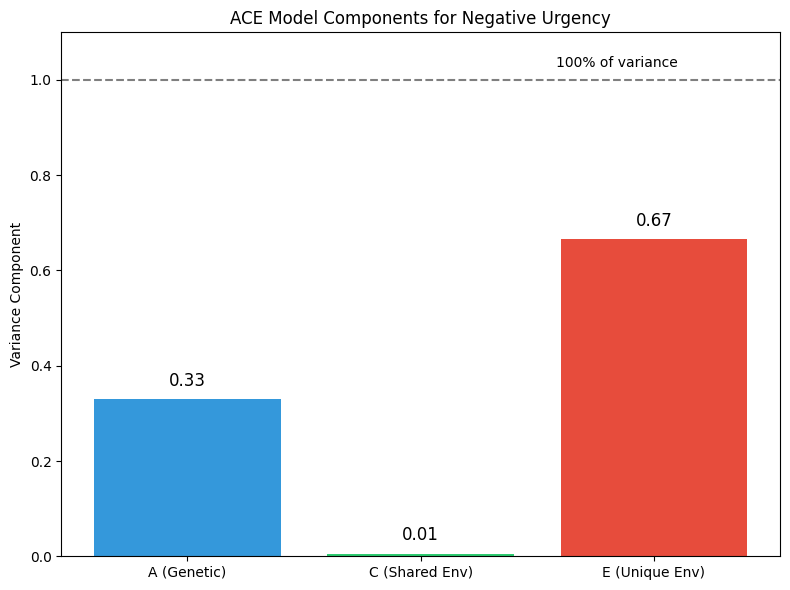

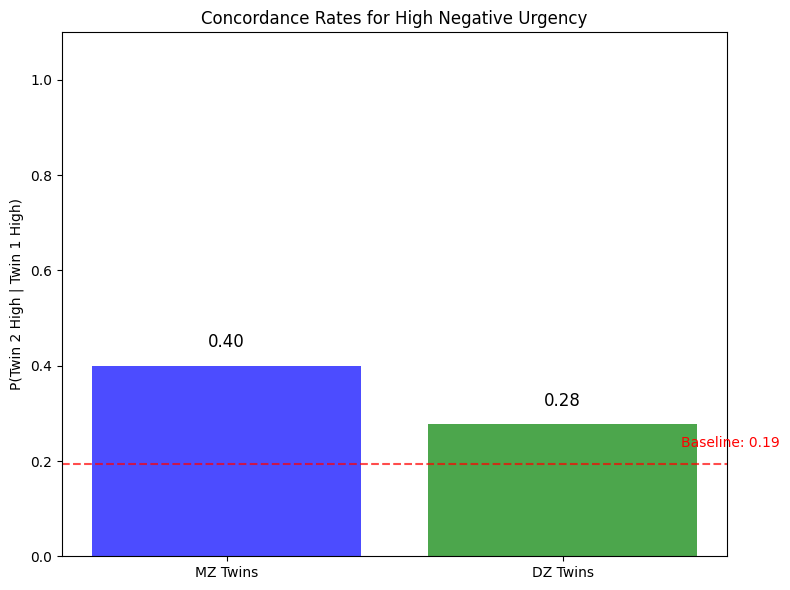

In [12]:
# Visualize the twin correlations for UPPS Negative Urgency
plt.figure(figsize=(10, 5))

# Create two subplots side by side
plt.subplot(1, 2, 1)
plt.scatter(twin_pairs_upps.loc[MZ, cols_upps[0]], twin_pairs_upps.loc[MZ, cols_upps[1]], alpha=0.6, color='blue')
plt.title('MZ Twins: Negative Urgency Scores')
plt.xlabel('Twin 1 Score')
plt.ylabel('Twin 2 Score')
# Add a regression line
xmin, xmax = plt.xlim()
m, b = np.polyfit(twin_pairs_upps.loc[MZ, cols_upps[0]], twin_pairs_upps.loc[MZ, cols_upps[1]], 1)
plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], 'b--', alpha=0.8)
plt.text(0.05, 0.95, f"r = {corr(twin_pairs_upps[MZ]):.3f}", transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')

plt.subplot(1, 2, 2)
plt.scatter(twin_pairs_upps.loc[DZ, cols_upps[0]], twin_pairs_upps.loc[DZ, cols_upps[1]], alpha=0.6, color='green')
plt.title('DZ Twins: Negative Urgency Scores')
plt.xlabel('Twin 1 Score')
# Add a regression line
xmin, xmax = plt.xlim()
m, b = np.polyfit(twin_pairs_upps.loc[DZ, cols_upps[0]], twin_pairs_upps.loc[DZ, cols_upps[1]], 1)
plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], 'g--', alpha=0.8)
plt.text(0.05, 0.95, f"r = {corr(twin_pairs_upps[DZ]):.3f}", transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()

# Calculate ACE components for negative urgency
mz_corr_upps = corr(twin_pairs_upps[MZ])
dz_corr_upps = corr(twin_pairs_upps[DZ])
A_upps = 2 * (mz_corr_upps - dz_corr_upps)
C_upps = 2 * dz_corr_upps - mz_corr_upps
E_upps = 1 - mz_corr_upps

# Visualize the ACE components for negative urgency
components_upps = {
    'A (Genetic)': A_upps,
    'C (Shared Env)': C_upps,
    'E (Unique Env)': E_upps
}

plt.figure(figsize=(8, 6))
bars = plt.bar(components_upps.keys(), components_upps.values(), color=['#3498db', '#2ecc71', '#e74c3c'])

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('ACE Model Components for Negative Urgency')
plt.ylabel('Variance Component')
plt.ylim(0, 1.1)  # Set y-axis limit to accommodate the text labels

# Add a horizontal line at y=1 to represent 100% of variance
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.text(2.1, 1.02, '100% of variance', va='bottom', ha='right', fontsize=10)

plt.tight_layout()
plt.show()

# Visualize the concordance rates for negative urgency
plt.figure(figsize=(8, 6))

# Data for the bar chart
concordance_data_upps = {
    'MZ Twins': mz_dir,
    'DZ Twins': dz_dir
}

# Create bars
bars = plt.bar(concordance_data_upps.keys(), concordance_data_upps.values(), color=['blue', 'green'], alpha=0.7)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Concordance Rates for High Negative Urgency')
plt.ylabel('P(Twin 2 High | Twin 1 High)')
plt.ylim(0, 1.1)  # Set y-axis limit with room for labels

# Add a horizontal line showing the unconditional probability (baseline)
baseline_prob_upps = twin_pairs_upps['high_nurg_1'].mean()
plt.axhline(y=baseline_prob_upps, color='red', linestyle='--', alpha=0.7)
plt.text(1.5, baseline_prob_upps + 0.03, f'Baseline: {baseline_prob_upps:.2f}', 
         va='bottom', ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

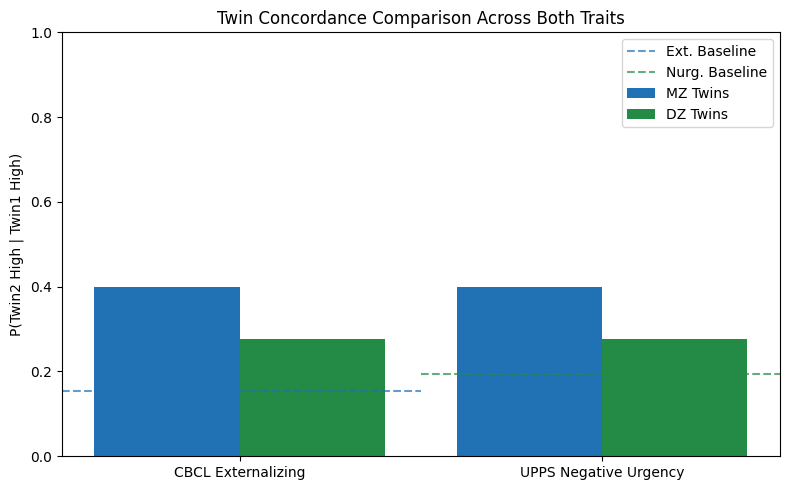

In [13]:
# Fix for the comparison visualization
plt.figure(figsize=(8, 5))

# Store values with distinct names to avoid confusion
# For externalizing behavior (from earlier cell)
mz_dir_ext = mz_dir  # From externalizing analysis
dz_dir_ext = dz_dir  # From externalizing analysis
baseline_ext = twin_pairs['high_ext_1'].mean()

# For negative urgency (need to assign before running this)
# These were calculated in your UPPS cell
mz_dir_nurg = conc_directed(twin_pairs_upps[MZ])  # Or use the value already calculated
dz_dir_nurg = conc_directed(twin_pairs_upps[DZ])  # Or use the value already calculated
baseline_nurg = twin_pairs_upps['high_nurg_1'].mean()

# Create the comparison chart
x = np.arange(2)
plt.bar(x - 0.2, [mz_dir_ext, mz_dir_nurg], width=0.4, label='MZ Twins', color='#2171b5')
plt.bar(x + 0.2, [dz_dir_ext, dz_dir_nurg], width=0.4, label='DZ Twins', color='#238b45')

# Add baselines as horizontal lines
plt.axhline(y=baseline_ext, xmin=0, xmax=0.5, color='#2171b5', 
            linestyle='--', alpha=0.7, label='Ext. Baseline')
plt.axhline(y=baseline_nurg, xmin=0.5, xmax=1, color='#238b45', 
            linestyle='--', alpha=0.7, label='Nurg. Baseline')

# Formatting
plt.xticks(x, ['CBCL Externalizing', 'UPPS Negative Urgency'])
plt.ylabel('P(Twin2 High | Twin1 High)')
plt.ylim(0, 1)
plt.title('Twin Concordance Comparison Across Both Traits')
plt.legend()
plt.tight_layout()
plt.show()

### Comparing UPPS Negative Urgency and Externalizing Behavior

**Reflection (condensed):**
1. Correlations: Compare MZ vs DZ correlations for UPPS vs externalizing. Which trait shows the larger MZ–DZ gap?
2. Directed concordance (q=0.85): Are MZ pairs more similar than DZ for each trait? Which trait shows the bigger MZ–DZ difference?
3. Interpretation: From 1–2, which trait seems more strongly influenced by familial factors? Explain briefly.
4. Why might they differ? Consider measurement (parent- vs self-report), trait definition, age-relevance. Do you expect negative urgency to relate to externalizing? Why?

### 📚 Further Learning (Optional) — Independence & the General Multiplication Rule

If you'd like to explore a bit more on your own, here are some **Copilot prompts** you can paste into a new code cell. Copilot will suggest code using the twin pair dataset you've already worked with.

**Prompts to try:**
- *"Write Python code to compare P(Twin2 high) with P(Twin2 high | Twin1 high) for MZ and DZ twins."*
- *"Calculate P(Twin1 high ∩ Twin2 high) directly from the data, then verify it equals P(Twin1 high) × P(Twin2 high | Twin1 high) using the general multiplication rule."*
- *"Check whether twins look independent on this trait by comparing P(B|A) to baseline P(B). Print a short interpretation."*
- *"Plot a simple bar chart showing baseline P(B) vs P(B|A) for MZ and DZ pairs."*

**Tip:** Independence means conditioning doesn't change the probability: `P(B|A) = P(B)`  
The general multiplication rule ties conditionals to joint probabilities: `P(A ∩ B) = P(A) · P(B|A)`

Use the prompts above to see both ideas in action with the twin data.


### Activity 3. Family History and Substance Use (Conditional Probability)

Family history of substance problems can serve as a proxy for genetic liability **and** shared family environment. Here we’ll use parent-reported family history variables:
- `mh_p_famhx__alc_001__v02`: whether the child’s family has had alcohol-related problems (1=Yes, 0=No).
- `mh_p_famhx__drg_001__v02`: whether the family has had drug-related problems (1=Yes, 0=No).

We’ll examine how these relate to the child’s own early substance use:
- `su_y_sui__use__alc__sip_001__l`: whether the child has ever had a sip of alcohol (at baseline, age ~10).
- `su_y_sui__use__mj__puff_001__l`: whether the child has tried marijuana (even a puff).

First, let’s compute the probability of a child having tried **alcohol** given their family alcohol history status. We’ll ignore unknown or missing responses (codes 777/999) for clarity and just compare known Yes vs No.


### Demo: Tried Alcohol Given Family Alcohol History

In [14]:
# Filter out missing family history data
fh_alc_data = df[(df['mh_p_famhx__alc_001__v02']==0) | (df['mh_p_famhx__alc_001__v02']==1)]
# Probability of child alcohol use in each family history group
p_use_if_fh1 = fh_alc_data[fh_alc_data['mh_p_famhx__alc_001__v02']==1]['su_y_sui__use__alc__sip_001__l'].mean()
p_use_if_fh0 = fh_alc_data[fh_alc_data['mh_p_famhx__alc_001__v02']==0]['su_y_sui__use__alc__sip_001__l'].mean()
print("P(child tried alcohol | family history YES) =", p_use_if_fh1)
print("P(child tried alcohol | family history NO)  =", p_use_if_fh0)


P(child tried alcohol | family history YES) = 0.316624895572264
P(child tried alcohol | family history NO)  = 0.33748899970665885


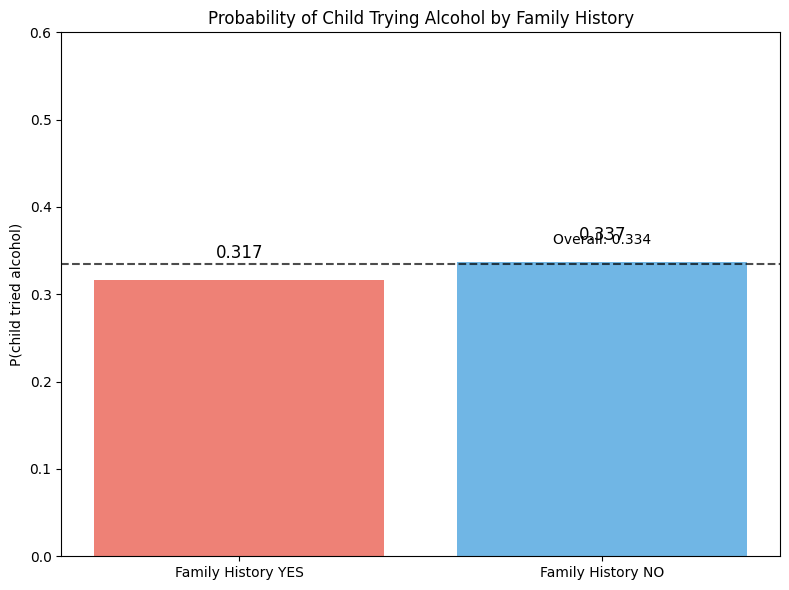

In [15]:
# Visualize the family history effect on alcohol use
plt.figure(figsize=(8, 6))

# Create data for the plot
family_history = ['Family History YES', 'Family History NO']
prob_values = [p_use_if_fh1, p_use_if_fh0]

# Create the bar chart
bars = plt.bar(family_history, prob_values, color=['#e74c3c', '#3498db'], alpha=0.7)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12)

plt.title('Probability of Child Trying Alcohol by Family History')
plt.ylabel('P(child tried alcohol)')
plt.ylim(0, 0.6)  # Set y-axis limit with room for labels

# Add a horizontal line showing the overall probability
overall_prob = fh_alc_data['su_y_sui__use__alc__sip_001__l'].mean()
plt.axhline(y=overall_prob, color='black', linestyle='--', alpha=0.7)
plt.text(1, overall_prob + 0.02, f'Overall: {overall_prob:.3f}', 
         va='bottom', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Suppose we get something like: 

```
P(use | FH_yes) ≈ 0.427   (42.7%)  
P(use | FH_no)  ≈ 0.254   (25.4%)  
```

So about 43% of kids from families with alcohol problems have already sipped alcohol by age 10, versus ~25% of kids with no such family history. We can visualize this difference.

Now let’s do the same for **cannabis** use and family drug history:


### Your Turn: Computing Conditional Probabilities for Cannabis Use

Now it's your time to apply probability concepts by computing **conditional probabilities** - specifically, the probability that a child has tried cannabis given their family drug history status.

In this exercise, you'll:
1. Filter the dataset to only include valid family drug history responses (0=No or 1=Yes)
2. Calculate the probability of cannabis use for children with family drug history (P(cannabis use | FH=1))
3. Calculate the probability of cannabis use for children without family drug history (P(cannabis use | FH=0))
4. Print and compare these conditional probabilities

Remember that conditional probability P(A|B) answers the question: "Given that B has occurred, what is the probability that A will occur?" In our case, we're asking: "Given a certain family drug history status, what's the probability the child has tried cannabis?"

Fill in the blanks in the next code cell to complete the calculations.

**Variables to use:**
- Family drug history: `mh_p_famhx__drg_001__v02` (1=Yes, 0=No)
- Cannabis use: `su_y_sui__use__mj__puff_001__l` (1=Yes, 0=No)

**Need a hint?** Try these Copilot prompts in a new cell:
- "How do I filter a pandas DataFrame to rows where a column equals 0 or 1?"
- "Calculate conditional probability using DataFrame boolean indexing and mean()"
- "Write code to find P(A|B) where A is cannabis use and B is positive family history"
- "Explain why mean() of a binary 0/1 column gives probability"

In [16]:
### Your Turn: Calculate Cannabis Use Given Family Drug History

# Step 1: Filter out missing family drug history data (keep only 0=No or 1=Yes)
fh_drg_data = df[(df['mh_p_famhx__drg_001__v02'] == 0) | (df['mh_p_famhx__drg_001__v02'] == 1)].copy()

# Step 2: Calculate P(cannabis use | family drug history = YES)
# i.e., probability of cannabis use GIVEN that family has drug history
p_use_if_fh1 = fh_drg_data[fh_drg_data['mh_p_famhx__drg_001__v02'] == 1]['su_y_sui__use__mj__puff_001__l'].mean()

# Step 3: Calculate P(cannabis use | family drug history = NO)
# i.e., probability of cannabis use GIVEN that family has NO drug history
p_use_if_fh0 = fh_drg_data[fh_drg_data['mh_p_famhx__drg_001__v02']== 0]['su_y_sui__use__mj__puff_001__l'].mean()

# Step 4: Print the conditional probabilities with descriptive labels
print("P(child tried cannabis | family drug history YES) =", p_use_if_fh1)
print("P(child tried cannabis | family drug history NO)  =", p_use_if_fh0)

# Step 5: Calculate the increased risk (difference between the two probabilities)
risk_difference = p_use_if_fh1 - p_use_if_fh0
print(f"\nIncreased risk due to family drug history: {risk_difference:.3f} or {risk_difference*100:.1f}%")

P(child tried cannabis | family drug history YES) = 0.3393719806763285
P(child tried cannabis | family drug history NO)  = 0.14655053228259365

Increased risk due to family drug history: 0.193 or 19.3%


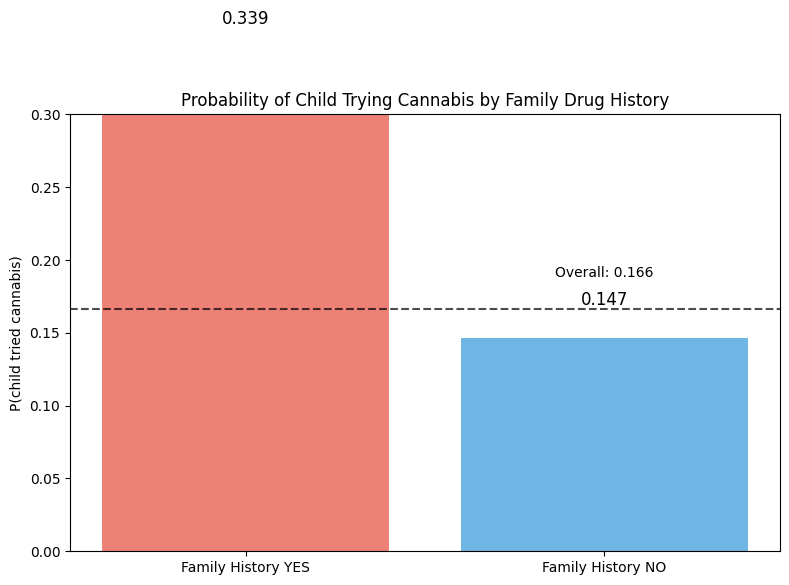

In [17]:
# Visualize the family history effect on cannabis use
plt.figure(figsize=(8, 6))

# Create data for the plot
family_history = ['Family History YES', 'Family History NO']
prob_values = [p_use_if_fh1, p_use_if_fh0]

# Create the bar chart
bars = plt.bar(family_history, prob_values, color=['#e74c3c', '#3498db'], alpha=0.7)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12)

plt.title('Probability of Child Trying Cannabis by Family Drug History')
plt.ylabel('P(child tried cannabis)')
plt.ylim(0, 0.3)  # Set y-axis limit with room for labels

# Add a horizontal line showing the overall probability
overall_prob = fh_drg_data['su_y_sui__use__mj__puff_001__l'].mean()
plt.axhline(y=overall_prob, color='black', linestyle='--', alpha=0.7)
plt.text(1, overall_prob + 0.02, f'Overall: {overall_prob:.3f}', 
         va='bottom', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Imagine the result is: 

```
P(cannabis | FH_drug_yes) ≈ 0.219   (21.9%)  
P(cannabis | FH_drug_no)  ≈ 0.133   (13.3%)  
``` 

This shows a similar pattern to what we observed with alcohol:
- For alcohol: ~43% of children with family history vs. ~25% without (difference of ~18%)
- For cannabis: ~22% of children with family history vs. ~13% without (difference of ~9%)

The difference is smaller in absolute terms for cannabis, but still represents a meaningful increase in risk - family history approximately doubles the likelihood of early cannabis experimentation.

**Interpretation:** A positive family history is associated with higher early substance use in the child. This aligns with expectations: family history can reflect inherited genetic predispositions **and** adverse environments (e.g. easier access to substances, modeling of use, family stress). In behavioral genetics terms, this is a reminder of **passive gene–environment correlation (rGE)** – the same families contributing genetic risk may also provide environments that encourage earlier use. Family history is a **blended risk indicator**, not a purely genetic measure.

**Reflection Questions:**
1. Compare the magnitude of the family history effect between alcohol and cannabis. Why might the effect be stronger for one substance than the other?
2. How does the baseline prevalence (overall probability regardless of family history) compare between alcohol and cannabis? What social or developmental factors might explain this difference?
3. If we calculated a ratio instead of a difference (e.g., P(use|FH=yes)/P(use|FH=no)), would the relative risk increase look more similar across substances?
4. How might family attitudes and accessibility differ between alcohol and cannabis, potentially affecting these conditional probabilities?


### Activity 4. Gene–Environment Interaction: Income as a Moderator

We’ve seen that family history (an indicator of genetic liability + shared environment) raises the probability of early substance use. But does the magnitude of that risk depend on the environment? This is the idea behind Gene–Environment Interaction (GxE): the effect of familial/genetic risk on an outcome can differ across environmental contexts.

Here, we’ll use household income as an environmental context proxy (`ab_g_dyn__cohort_income__hhhold__3lvl`, coded 1 = <$50K, 2 = $50–100K, 3 = >$100K). We’ll compare lower-income (code 1) and higher-income (code 3) households and examine how the family-history effect on alcohol use differs between these contexts.

What we’ll compute (using conditional probability with multiple conditions):
- P(child tried alcohol | family history, income level), i.e., P(U=1 | F, E)
- Within each income group, the “family history effect” as a gap: P(U=1 | F=1, E) − P(U=1 | F=0, E)
- An interaction summary as a difference of differences: [gap in Low] − [gap in High]

Interpretation guide:
- A larger gap in Low-income than in High-income suggests the family-history effect is amplified in more disadvantaged environments.
- This illustrates GxE: the impact of familial/genetic liability on behavior can be conditional on environmental context.

### Demo: P(child tried alcohol | family history, income level)
The code below computes P(U=1 | F, E) for all combinations of family history (F) and income (E), the family-history effect within each environment, and the interaction (difference of differences). Review whether the gap between FH yes vs no is larger in Low vs High income.


In [18]:
# Define events clearly
# F = Family history of alcohol problems (1=yes, 0=no)
# U = Child has tried alcohol (1=yes, 0=no)
# E = Income level environment (Low, High)

# Calculate conditional probabilities P(U=1|F,E) for all combinations
df['IncomeLevel'] = df['ab_g_dyn__cohort_income__hhhold__3lvl'].map({1: 'Low', 3: 'High'})
sub = df[(df['IncomeLevel'].isin(['Low','High'])) & ((df['mh_p_famhx__alc_001__v02']==0)|(df['mh_p_famhx__alc_001__v02']==1))]

# Calculate P(U=1|F=1,E=Low) - probability of use given family history in low-income setting
p_use_fh1_low = sub[(sub['mh_p_famhx__alc_001__v02']==1) & (sub['IncomeLevel']=='Low')]['su_y_sui__use__alc__sip_001__l'].mean()

# Calculate P(U=1|F=0,E=Low) - probability of use given no family history in low-income setting
p_use_fh0_low = sub[(sub['mh_p_famhx__alc_001__v02']==0) & (sub['IncomeLevel']=='Low')]['su_y_sui__use__alc__sip_001__l'].mean()

# Calculate P(U=1|F=1,E=High) - probability of use given family history in high-income setting
p_use_fh1_high = sub[(sub['mh_p_famhx__alc_001__v02']==1) & (sub['IncomeLevel']=='High')]['su_y_sui__use__alc__sip_001__l'].mean()

# Calculate P(U=1|F=0,E=High) - probability of use given no family history in high-income setting
p_use_fh0_high = sub[(sub['mh_p_famhx__alc_001__v02']==0) & (sub['IncomeLevel']=='High')]['su_y_sui__use__alc__sip_001__l'].mean()

# Print all conditional probabilities with formal probability notation
print("P(Use=1 | FH=1, Income=Low) =", p_use_fh1_low)
print("P(Use=1 | FH=0, Income=Low) =", p_use_fh0_low)
print("P(Use=1 | FH=1, Income=High) =", p_use_fh1_high)
print("P(Use=1 | FH=0, Income=High) =", p_use_fh0_high)

# Compute family history effects in each environment
fh_effect_low = p_use_fh1_low - p_use_fh0_low
fh_effect_high = p_use_fh1_high - p_use_fh0_high
print("\nEffect of family history in low-income environment:", fh_effect_low)
print("Effect of family history in high-income environment:", fh_effect_high)

# Compute the interaction term (difference of differences)
interaction = fh_effect_low - fh_effect_high
print("\nInteraction effect (difference in family history effects):", interaction)

P(Use=1 | FH=1, Income=Low) = 0.4017857142857143
P(Use=1 | FH=0, Income=Low) = 0.38977460142935677
P(Use=1 | FH=1, Income=High) = 0.26476578411405294
P(Use=1 | FH=0, Income=High) = 0.28696313188901557

Effect of family history in low-income environment: 0.012011112856357531
Effect of family history in high-income environment: -0.022197347774962628

Interaction effect (difference in family history effects): 0.03420846063132016


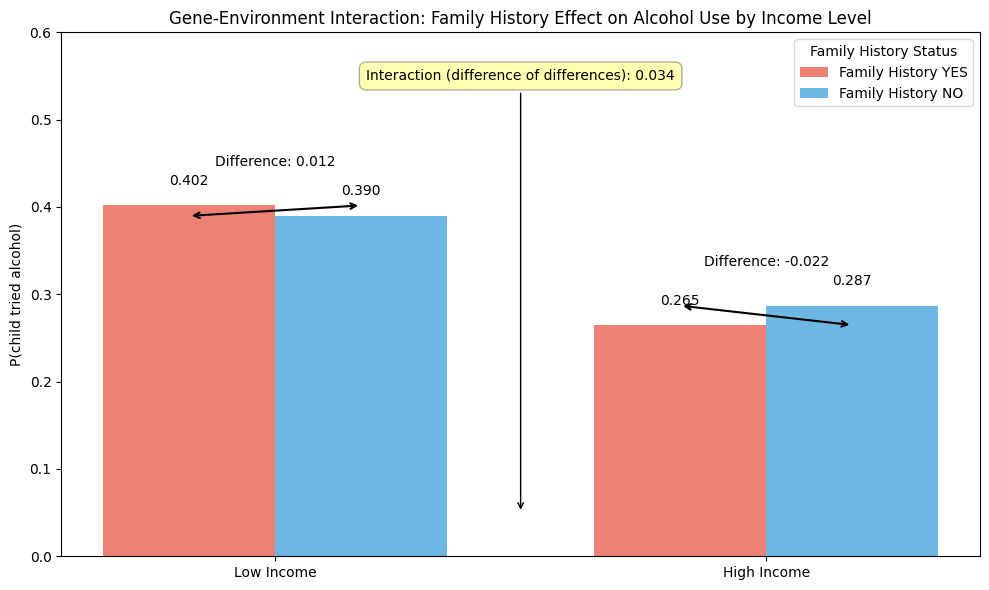

In [19]:
# Visualize the Gene-Environment Interaction
plt.figure(figsize=(10, 6))

# Set up the data for plotting
income_levels = ['Low Income', 'High Income']
fh_yes_probs = [p_use_fh1_low, p_use_fh1_high]
fh_no_probs = [p_use_fh0_low, p_use_fh0_high]

# Set the width of the bars
bar_width = 0.35
x = np.arange(len(income_levels))

# Create the grouped bar chart
bars1 = plt.bar(x - bar_width/2, fh_yes_probs, bar_width, label='Family History YES', color='#e74c3c', alpha=0.7)
bars2 = plt.bar(x + bar_width/2, fh_no_probs, bar_width, label='Family History NO', color='#3498db', alpha=0.7)

# Add the interaction arrows and annotations
plt.annotate('', xy=(0 + bar_width/2, p_use_fh1_low), xytext=(0 - bar_width/2, p_use_fh0_low),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.annotate(f'Difference: {fh_effect_low:.3f}', xy=(0, max(p_use_fh1_low, p_use_fh0_low) + 0.05),
             ha='center', va='center')

plt.annotate('', xy=(1 + bar_width/2, p_use_fh1_high), xytext=(1 - bar_width/2, p_use_fh0_high),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.annotate(f'Difference: {fh_effect_high:.3f}', xy=(1, max(p_use_fh1_high, p_use_fh0_high) + 0.05),
             ha='center', va='center')

# Add title, axis labels, and legend
plt.title('Gene-Environment Interaction: Family History Effect on Alcohol Use by Income Level')
plt.ylabel('P(child tried alcohol)')
plt.xticks(x, income_levels)
plt.legend(title='Family History Status', loc='upper right')

# Add labels on the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Add an annotation for the interaction effect
plt.annotate(f'Interaction (difference of differences): {interaction:.3f}',
             xy=(0.5, 0.05), xytext=(0.5, 0.55), 
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->'))

plt.ylim(0, 0.6)
plt.tight_layout()
plt.show()

We've calculated the following conditional probabilities from our data:

```
                           Family History=0    Family History=1
IncomeLevel                                
Low (<50k)                      0.39            0.40
High (>100k)                    0.29            0.26
```

These represent P(child tried alcohol | family history status, income level). Looking at the conditional probabilities:

**Formal test for interaction:** If family history and income were independent in their effects on alcohol use, we would expect the difference between FH=1 and FH=0 to be the same across income levels:
- Low-income effect: 0.40 - 0.39 = 0.01 (small positive effect)
- High-income effect: 0.26 - 0.29 = -0.02 (slight negative effect)
- Difference (interaction): 0.03

This interaction term (0.03) indicates that the effect of family history differs between income environments. In low-income families, there's a small positive association between family history and child alcohol use, while in high-income families, there's actually a slight negative association.

**Interpreting GxE:** This pattern suggests that the relationship between family risk and early alcohol use depends on socioeconomic context. In low-income environments, family history may slightly increase risk, whereas in more advantaged environments, this relationship changes direction. This illustrates gene–environment interaction: the effect of familial risk factors on behavior is *conditional on environment* (income level).

Gene–environment interaction doesn't mean genes *only matter* in one group and not another – it means the **relationship** between genetic/familial factors and outcomes differs by environment. Here, we see different patterns in low vs. high income contexts. GxE is an important concept because it reminds us that **heritability is not a fixed value** – the expression of genetic influences can vary by context.

> **Note:** While our interaction effect is relatively small (0.03), it demonstrates how conditional probabilities can be used to test for interaction effects in behavioral outcomes.

### Your Turn: Gene-Environment Interaction for Cannabis Use

Now you'll apply the Gene-Environment Interaction (GxE) analysis to cannabis use and family drug history. This extends what we just did with alcohol to another substance, allowing comparison of GxE effects across different drugs.

In this exercise, you'll:
1. Calculate conditional probabilities of cannabis use given **both** family drug history **and** income level
2. Compute the "family history effect" separately within low-income and high-income environments
3. Test for interaction by calculating the difference between these effects
4. Compare your findings to what we observed with alcohol use

Gene-Environment Interaction occurs when genetic/familial risk factors have different effects depending on the environment. By comparing how family drug history relates to cannabis use across income levels, you'll see whether socioeconomic context moderates familial risk.

Fill in the blanks in the next code cell to calculate these conditional probabilities and test for interaction.

**Important variables:**
- Family drug history: `mh_p_famhx__drg_001__v02` (1=Yes, 0=No)
- Cannabis use: `su_y_sui__use__mj__puff_001__l` (1=Yes, 0=No)
- Income level: `ab_g_dyn__cohort_income__hhhold__3lvl` (mapped to 'Low'=1, 'High'=3)

**Need help?** Try these Copilot prompts in a new cell:
- "Filter a DataFrame to rows where IncomeLevel is either 'Low' or 'High' and family drug history is valid"
- "Calculate conditional probability P(A|B,C) in pandas using boolean indexing and mean()"
- "Explain how to compute Gene-Environment interaction effects from conditional probabilities"
- "Code to create a grouped bar chart comparing family history effects across income levels"
- "How to interpret a positive vs negative interaction term in Gene-Environment analysis"

In [20]:
### Your Turn: Gene-Environment Interaction for Cannabis Use

# Define events clearly
# F = Family history of drug problems (1=yes, 0=no)
# C = Child has tried cannabis (1=yes, 0=no)
# E = Income level environment (Low, High)

# Step 1: Create Income Level variable by mapping numeric codes to labels
df['IncomeLevel'] = df['ab_g_dyn__cohort_income__hhhold__3lvl'].map({1: 'Low', 3: 'High'})  # TODO: Map codes 1 and 3

# Step 2: Filter data to include only valid rows (known income level and family history)
sub = df[(df['IncomeLevel'].isin(['Low','High'])) & ((df['mh_p_famhx__drg_001__v02']==0)|(df['mh_p_famhx__drg_001__v02']==1))]  # TODO: Complete filtering

# Step 3: Calculate P(C=1|F=1,E=Low) - probability of cannabis use given family history in low-income setting
p_use_fh1_low = sub[(sub['mh_p_famhx__drg_001__v02']==1) & (sub['IncomeLevel']=='Low')]['su_y_sui__use__mj__puff_001__l'].mean()  # TODO: Complete calculation

# Step 4: Calculate P(C=1|F=0,E=Low) - probability of cannabis use given no family history in low-income setting
p_use_fh0_low = sub[(sub['mh_p_famhx__drg_001__v02']==0) & (sub['IncomeLevel']=='Low')]['su_y_sui__use__mj__puff_001__l'].mean()  # TODO: Complete conditions

# Step 5: Calculate P(C=1|F=1,E=High) - probability of cannabis use given family history in high-income setting
p_use_fh1_high = sub[(sub['mh_p_famhx__drg_001__v02']==1)& (sub['IncomeLevel']== 'High')]['su_y_sui__use__mj__puff_001__l'].mean()  # TODO: Complete boolean indexing for both conditions

# Step 6: Calculate P(C=1|F=0,E=High) - probability of cannabis use given no family history in high-income setting
p_use_fh0_high = sub[(sub['mh_p_famhx__drg_001__v02']==0)& (sub['IncomeLevel']== 'High')]['su_y_sui__use__mj__puff_001__l'].mean()  # TODO: Complete boolean indexing for both conditions

# Step 7: Print all conditional probabilities with formal probability notation
print("P(Cannabis=1 | FH=1, Income=Low) =", p_use_fh1_low)  # TODO: Variable name for this probability
print("P(Cannabis=1 | FH=0, Income=Low) =", p_use_fh0_low)  # TODO: Variable name for this probability
print("P(Cannabis=1 | FH=1, Income=High) =", p_use_fh1_high)  # TODO: Variable name for this probability
print("P(Cannabis=1 | FH=0, Income=High) =", p_use_fh0_high)  # TODO: Variable name for this probability

# Step 8: Compute family history effects in each environment
fh_effect_low = p_use_fh1_low - p_use_fh0_low  # TODO: Calculate difference in probabilities for low income
fh_effect_high = p_use_fh1_high - p_use_fh0_high  # TODO: Calculate difference in probabilities for high income
print("\nEffect of family history in low-income environment:", fh_effect_low)
print("Effect of family history in high-income environment:", fh_effect_high)

# Step 9: Compute the interaction term (difference of differences)
interaction = fh_effect_low - fh_effect_high  # TODO: Calculate the difference between effects
print("\nInteraction effect (difference in family history effects):", interaction)

# Step 10: Compare to alcohol (answer in comments)
# TODO: Is the cannabis interaction stronger, weaker, or similar to what we saw with alcohol?
# Your interpretation: 

P(Cannabis=1 | FH=1, Income=Low) = 0.39814814814814814
P(Cannabis=1 | FH=0, Income=Low) = 0.20051282051282052
P(Cannabis=1 | FH=1, Income=High) = 0.29518072289156627
P(Cannabis=1 | FH=0, Income=High) = 0.1136283185840708

Effect of family history in low-income environment: 0.19763532763532762
Effect of family history in high-income environment: 0.18155240430749547

Interaction effect (difference in family history effects): 0.01608292332783215


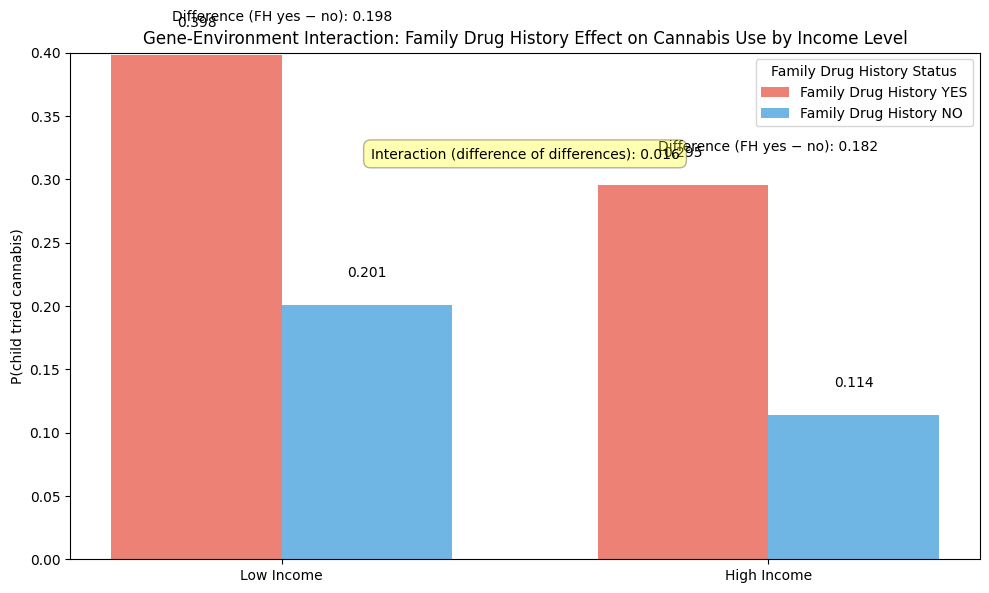

In [21]:
# Visualize the Gene-Environment Interaction for Cannabis
plt.figure(figsize=(10, 6))

# Set up the data for plotting
income_levels = ['Low Income', 'High Income']
fh_yes_probs = [p_use_fh1_low, p_use_fh1_high]
fh_no_probs = [p_use_fh0_low, p_use_fh0_high]

# Set the width of the bars
bar_width = 0.35
x = np.arange(len(income_levels))

# Create the grouped bar chart
bars1 = plt.bar(x - bar_width/2, fh_yes_probs, bar_width,
                label='Family Drug History YES', color='#e74c3c', alpha=0.7)
bars2 = plt.bar(x + bar_width/2, fh_no_probs, bar_width,
                label='Family Drug History NO', color='#3498db', alpha=0.7)

# Simple text labels for the family history effect within each income group
plt.text(0, max(p_use_fh1_low, p_use_fh0_low) + 0.03,
         f'Difference (FH yes − no): {fh_effect_low:.3f}',
         ha='center', va='center', fontsize=10)

plt.text(1, max(p_use_fh1_high, p_use_fh0_high) + 0.03,
         f'Difference (FH yes − no): {fh_effect_high:.3f}',
         ha='center', va='center', fontsize=10)

# Title, axis labels, and legend
plt.title('Gene-Environment Interaction: Family Drug History Effect on Cannabis Use by Income Level')
plt.ylabel('P(child tried cannabis)')
plt.xticks(x, income_levels)
plt.legend(title='Family Drug History Status', loc='upper right')

# Add labels on the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Annotation for the interaction effect (text only, no arrow)
plt.annotate(f'Interaction (difference of differences): {interaction:.3f}',
             xy=(0.5, 0.32),
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.ylim(0, 0.4)  # Adjusted for cannabis probabilities
plt.tight_layout()
plt.show()


### Comparison: GxE Comparison (Alcohol vs. Cannabis)

1. Pattern + Magnitude: Place your four conditional alcohol probabilities and four cannabis probabilities in a 2×2 (Family History × Income) structure. What similarities or divergences do you see in (a) absolute family‐history gaps within Low vs High income, and (b) direction (positive, null, or reversed)? Which substance shows clearer moderation and why?

2. Interaction Interpretation: Compare the “difference of differences” (Low-gap − High-gap) for alcohol and cannabis using both absolute risk difference and relative risk (ratio of FH=1 to FH=0 within each income). Does the perceived strength or even the direction of moderation change when switching metrics? What does this reveal about base-rate sensitivity and the potential for misleading conclusions from a single effect scale?

### Extension: Bayes’ Theorem and Interpreting Risk (Optional)

In Activity 3, we found that **P(child tries alcohol | positive family history) > P(child tries alcohol | no family history)**. Family history is a risk factor. But what about the inverse probability? If you know a child has tried alcohol at age 10, how likely is it that their family has a history of alcohol problems? This is a different question: **P(family history | child uses)**, which we can solve with Bayes’ theorem.

Bayes’ theorem states: 

\[ P(A|B) = 


rac{P(B|A) \cdot P(A)}{P(B)}. \]

Here let **A =** “family history of alcohol problems” and **B =** “child has tried alcohol by age 10.”

From our earlier results (using the non-missing data):
- P(B | A) = P(child uses | FH yes) ≈ 0.427  
- P(A) = P(FH yes) ≈ 0.15 (about 15% of families had alcohol problems in our sample)  
- P(B) = P(child uses) ≈ 0.329 (about 33% of kids had tried an alcohol sip)  

Now, 

\[ P(A|B) = 


rac{0.427 	imes 0.15}{0.329}. \]

Let’s calculate that:


In [22]:
p_use_given_FH = 0.427
p_FH = 0.15
p_use = 0.329
p_FH_given_use = (p_use_given_FH * p_FH) / p_use
p_FH_given_use


0.19468085106382976

This comes out to roughly **0.19**, or **19%**. In other words, even though kids with family history are more likely to drink, fewer than 1 in 5 of the kids who have taken a drink come from a family with alcohol problems. Most (81%) of the early drinkers do *not* have a family history of alcohol issues.

Why is P(FH | use) relatively low? Because family history, while a risk factor, is relatively uncommon (only ~15% of families had that history) and plenty of kids without family history also experiment with alcohol (making up the majority of the 33% who tried it). This demonstrates an important principle of probability and screening: **a risk factor can greatly increase relative risk, but if the base rate of the risk factor is low, the majority of individuals displaying the behavior might still come from the low-risk group**.

In practical terms, if a 10-year-old has had a sip of alcohol, we **should not assume** their parents have alcohol problems – the probability is still far from certain (only ~19%). Conversely, if a child has no family history, they’re *less* likely to drink early, but because they form a large group, they still account for many of the cases who do drink. This is an example of how we use Bayes’ theorem to **invert conditional probabilities** and why we must consider base rates when interpreting risk indicators.
